# Capstone Project - The Battle of the Neighborhoods (Week 2)

## Table of Content
 - Business Problem
 - Data
 - Methodology
 - Analysis
 - Result and Discussion
 - Conclusion
 

## Business Problem
### This project defined to find a safe and secure location for opening of commercial establishments in Vancouver, BC, Canada. Specifically, this report will be targeted to stakeholders interested in opening any business place i.e. Liquor Store in the Vancouver City.

### Following are the steps that will be taken:
  - The first task would be to choose the safest borough by analyzing crime data.
  - Shortlisting a neighborhood, where liquor stores are not amongst the most common venues
  - As close to the city as possible.

### This project and its analysis will attract individuals who are interested in opening a liquor store.


## Data
##### Based on the business problem, factors that will influence the analysis are:
     - Reviewing the safest borough based on crime statistics
     - Reviewing the most common venues
     - Selecting the right neighborhood within the borough

##### For the capstone project we will be using the geographical coordinates of Vancouver to plot neighborhoods in a borough that is safe and in the city's vicinity, and finally cluster our neighborhoods and present the findings.

#### To extract/generate the required information, following are the steps and data sources will be needed:
     Step 1: Using data set from Kaggle containing the Vancouver Crimes from 2003 to 2019: A dataset consisting of the crime statistics of each Neighborhood in Vancouver along with type of crime, recorded year, month and hour.
     Step 2: Gathering additional data list to officially categorized boroughs in Vancouver from Wikipedia. This information will be used to map the existing data where each neighborhood can be assigned with its respective borough.
     Step 3: Creating a new consolidated dataset for the neighborhoods, along with their boroughs, crime data and the respective neighborhood's co-ordinates. The latitude and longitude data will be fetched using OpenCage Geocoder. To explore the neighborhood by plotting it on maps using Folium and perform exploratory data analysis.  
     Step 4: Creating a new consolidated dataset of the neighborhoods, boroughs, and the most common venues and the respective neighborhood along with co-ordinates.This data will be fetched using Four Square API to explore the neighborhood venues and to apply machine learning algorithm to cluster the neighborhoods and present the findings by plotting it on maps using Folium.

### Executing Step 1
Data set URL: https://www.kaggle.com/agilesifaka/vancouver-crime-report/version/2

### Importing Libraries required for the analysis

In [1]:
import numpy as np
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Command to install OpenCage Geocoder for fetching Lat and Lng of Neighborhood
!pip install opencage

#Importing OpenCage Geocoder
from opencage.geocoder import OpenCageGeocode

# use the inline backend to generate the plots within the browser
%matplotlib inline 

#Importing Matplot lib and associated packages to perform Data Visualisation and Exploratory Data Analysis
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#Importing folium to visualise Maps and plot based on Lat and Lng
import folium

#Requests to request web pages by making get requests to FourSquare REST Client
import requests

#To normalise data returned by FourSquare API
from pandas.io.json import json_normalize

#Importing KMeans from SciKit library to Classify neighborhoods into clusters
from sklearn.cluster import KMeans

print('Libraries imported')

Matplotlib version:  3.1.1
Libraries imported


### Dataset Analysis: For this project due to shear volume of dataset, only data gathered in 2018 is analyzed.

In [3]:
import pandas as pd
vnc_crime_df = pd.read_csv('crime_records_2018.csv', index_col=None)

#Dropping X,Y which represents Lat, Lng data as Coordinates, the data seems to be corrupt
vnc_crime_df.drop(['MINUTE', 'HUNDRED_BLOCK', 'X', 'Y'], axis = 1, inplace = True)

#vnc_crime_df.columns

vnc_crime_df.head()

,TYPE,YEAR,MONTH,DAY,HOUR,NEIGHBOURHOOD
0,Break and Enter Commercial,2018,3,2,6,West End
1,Break and Enter Commercial,2018,6,16,18,West End
2,Break and Enter Commercial,2018,12,12,0,West End
3,Break and Enter Commercial,2018,4,9,6,Central Business District
4,Break and Enter Commercial,2018,10,2,18,Central Business District


### Changing all uppercase case columns to lowercase


In [4]:
vnc_crime_df.columns = ['Type', 'Year','Month','Day','Hour','Neighbourhood']
vnc_crime_df.head()

,Type,Year,Month,Day,Hour,Neighbourhood
0,Break and Enter Commercial,2018,3,2,6,West End
1,Break and Enter Commercial,2018,6,16,18,West End
2,Break and Enter Commercial,2018,12,12,0,West End
3,Break and Enter Commercial,2018,4,9,6,Central Business District
4,Break and Enter Commercial,2018,10,2,18,Central Business District


### Analyzing crimes in the neighborhoods in Vancouver

In [5]:
vnc_crime_df['Neighbourhood'].value_counts()


Central Business District    10857
West End                      3031
Mount Pleasant                2396
Strathcona                    1987
Kitsilano                     1802
Fairview                      1795
Renfrew-Collingwood           1762
Grandview-Woodland            1761
Kensington-Cedar Cottage      1391
Hastings-Sunrise              1270
Sunset                         967
Riley Park                     866
Marpole                        828
Victoria-Fraserview            600
Killarney                      565
Oakridge                       499
Dunbar-Southlands              474
Kerrisdale                     417
Shaughnessy                    414
West Point Grey                372
Arbutus Ridge                  311
South Cambie                   292
Stanley Park                   154
Musqueam                        17
Name: Neighbourhood, dtype: int64

## Executing Step 2

In [6]:
# define the dataframe columns
column_names = ['Neighbourhood', 'Borough'] 

# instantiate the dataframe
vnc_neigh_bor = pd.DataFrame(columns=column_names)

vnc_neigh_bor['Neighbourhood'] = vnc_crime_df['Neighbourhood'].unique()

neigh_bor_dict = {'Central Business District':'Central', 'West End':'Central', 'Stanley Park':'Central', 'Victoria-Fraserview':'South Vancouver',
                  'Killarney':'South Vancouver', 'Musqueam':'South Vancouver', 'Mount Pleasant':'East Side', 'Strathcona':'East Side',
                  'Renfrew-Collingwood':'East Side', 'Grandview-Woodland':'East Side', 'Kensington-Cedar Cottage':'East Side', 'Hastings-Sunrise':'East Side',
                  'Sunset':'East Side', 'Riley Park':'East Side', 'Kitsilano':'West Side', 'Fairview':'West Side',
                  'Marpole':'West Side', 'Oakridge':'West Side', 'Dunbar-Southlands':'West Side', 'Kerrisdale':'West Side',
                  'Shaughnessy':'West Side', 'West Point Grey':'West Side', 'Arbutus Ridge':'West Side', 'South Cambie':'West Side'}

for row, neigh in zip(neigh_bor_dict, vnc_neigh_bor['Neighbourhood']):
  vnc_neigh_bor.loc[vnc_neigh_bor.Neighbourhood == row, 'Borough'] = neigh_bor_dict.get(row)

vnc_neigh_bor.dropna(inplace=True)

print("Total Neighbourhood Count",len(vnc_neigh_bor['Neighbourhood']),"Borough Count",len(vnc_neigh_bor['Borough'].unique()))

vnc_neigh_bor.head()

Total Neighbourhood Count 24 Borough Count 4


,Neighbourhood,Borough
0,West End,Central
1,Central Business District,Central
2,Hastings-Sunrise,East Side
3,Grandview-Woodland,East Side
4,Mount Pleasant,East Side


### Merging crime data with boroughs

In [7]:
vnc_boroughs_crime = pd.merge(vnc_crime_df,vnc_neigh_bor, on='Neighbourhood')

vnc_boroughs_crime.head()

,Type,Year,Month,Day,Hour,Neighbourhood,Borough
0,Break and Enter Commercial,2018,3,2,6,West End,Central
1,Break and Enter Commercial,2018,6,16,18,West End,Central
2,Break and Enter Commercial,2018,12,12,0,West End,Central
3,Break and Enter Commercial,2018,3,2,3,West End,Central
4,Break and Enter Commercial,2018,3,17,11,West End,Central


### Cleaning the data by dropping rows with invalid data


In [8]:
vnc_boroughs_crime.dropna(inplace=True)
vnc_boroughs_crime['Borough'].value_counts()

Central            14042
East Side          12400
West Side           7204
South Vancouver     1182
Name: Borough, dtype: int64

## Data Analysis Methodology

##### (1) Exploratory Data Analysis: Visualize the crime reports in different Vancouver boroughs to identify the safest borough and normalize the neighborhoods of that borough.

### <font size="2.5">Pivoting the table</font>

In [9]:
vnc_crime_cat = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Borough'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_cat

Year                                    \
Type            Break and Enter Commercial Break and Enter Residential/Other   
Borough                                                                        
Central                                787                               198   
East Side                              786                              1043   
South Vancouver                         49                               156   
West Side                              403                              1000   
All                                   2025                              2397   

                                                                          \
Type            Mischief Other Theft Theft from Vehicle Theft of Bicycle   
Borough                                                                    
Central             2280        2489               6871              857   
East Side           2192        1674               4754              678   
South Vancouver      187          88                483               36   
West Side           1062         696               2838              588   
All                 5721        4947              14946             2159   

                                  \
Type            Theft of Vehicle   
Borough                            
Central                      245   
East Side                    605   
South Vancouver               71   
West Side                    225   
All                         1146   

                                                                        \
Type            Vehicle Collision or Pedestrian Struck (with Fatality)   
Borough                                                                  
Central                                                          1       
East Side                                                        8       
South Vancouver                                                  1       
West Side                                                        3       
All                                                             13       

                                                                             
Type            Vehicle Collision or Pedestrian Struck (with Injury)    All  
Borough                                                                      
Central                                                        314    14042  
East Side                                                      660    12400  
South Vancouver                                                111     1182  
West Side                                                      389     7204  
All                                                           1474    34828

##### Merging the Pivoted Column with other columns


In [10]:
vnc_crime_cat.reset_index(inplace = True)
vnc_crime_cat.columns = vnc_crime_cat.columns.map(''.join)
vnc_crime_cat.rename(columns={'YearAll':'Total'}, inplace=True)
# To ignore bottom All in Borough
vnc_crime_cat = vnc_crime_cat.head(4)
vnc_crime_cat

,Borough,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
0,Central,787,198,2280,2489,6871,857,245,1,314,14042
1,East Side,786,1043,2192,1674,4754,678,605,8,660,12400
2,South Vancouver,49,156,187,88,483,36,71,1,111,1182
3,West Side,403,1000,1062,696,2838,588,225,3,389,7204


##### Analyze data by crimes per neighborhood

In [11]:

vnc_crime_neigh = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Neighbourhood'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_neigh

Year  \
Type                      Break and Enter Commercial   
Neighbourhood                                          
Arbutus Ridge                                     12   
Central Business District                        551   
Dunbar-Southlands                                  8   
Fairview                                         138   
Grandview-Woodland                               148   
Hastings-Sunrise                                  48   
Kensington-Cedar Cottage                          62   
Kerrisdale                                        24   
Killarney                                         34   
Kitsilano                                        106   
Marpole                                           44   
Mount Pleasant                                   205   
Musqueam                                           0   
Oakridge                                          19   
Renfrew-Collingwood                               91   
Riley Park                                        35   
Shaughnessy                                       12   
South Cambie                                      22   
Stanley Park                                       6   
Strathcona                                       160   
Sunset                                            37   
Victoria-Fraserview                               15   
West End                                         230   
West Point Grey                                   18   
All                                             2025   

                                                                      \
Type                      Break and Enter Residential/Other Mischief   
Neighbourhood                                                          
Arbutus Ridge                                            78       49   
Central Business District                               124     1812   
Dunbar-Southlands                                       106       81   
Fairview                                                 73      233   
Grandview-Woodland                                      162      304   
Hastings-Sunrise                                        117      195   
Kensington-Cedar Cottage                                145      255   
Kerrisdale                                               97       49   
Killarney                                                72       90   
Kitsilano                                               165      320   
Marpole                                                 125      134   
Mount Pleasant                                          124      353   
Musqueam                                                  4        3   
Oakridge                                                123       64   
Renfrew-Collingwood                                     156      243   
Riley Park                                              122      140   
Shaughnessy                                             120       41   
South Cambie                                             42       41   
Stanley Park                                              2        8   
Strathcona                                              124      527   
Sunset                                                   93      175   
Victoria-Fraserview                                      80       94   
West End                                                 72      460   
West Point Grey                                          71       50   
All                                                    2397     5721   

                                                                           \
Type                      Other Theft Theft from Vehicle Theft of Bicycle   
Neighbourhood                                                               
Arbutus Ridge                      18                111               12   
Central Business District        2034               5301              640   
Dunbar-Southlands                  31                199               16   


In [12]:
vnc_crime_neigh.reset_index(inplace = True)
vnc_crime_neigh.columns = vnc_crime_neigh.columns.map(''.join)
vnc_crime_neigh.rename(columns={'YearAll':'Total'}, inplace=True)

vnc_crime_neigh.head()

,Neighbourhood,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
0,Arbutus Ridge,12,78,49,18,111,12,12,1,18,311
1,Central Business District,551,124,1812,2034,5301,640,165,0,230,10857
2,Dunbar-Southlands,8,106,81,31,199,16,9,1,23,474
3,Fairview,138,73,233,297,692,245,55,0,62,1795
4,Grandview-Woodland,148,162,304,215,634,110,123,0,65,1761


##### Using Pandas describe() to view some basic statistical details like percentile, mean, std etc.

In [13]:
vnc_crime_cat.describe()

,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
count,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,506.250000,599.250000,1430.25000,1236.750000,3736.500000,539.750000,286.500000,3.250000,368.500000,8707.000000
std,354.409721,488.189427,997.26572,1060.087221,2723.536977,353.955153,226.117226,3.304038,227.060198,5801.870618
min,49.000000,156.000000,187.00000,88.000000,483.000000,36.000000,71.000000,1.000000,111.000000,1182.000000
25%,314.500000,187.500000,843.25000,544.000000,2249.250000,450.000000,186.500000,1.000000,263.250000,5698.500000
50%,594.500000,599.000000,1627.00000,1185.000000,3796.000000,633.000000,235.000000,2.000000,351.500000,9802.000000
75%,786.250000,1010.750000,2214.00000,1877.750000,5283.250000,722.750000,335.000000,4.250000,456.750000,12810.500000
max,787.000000,1043.000000,2280.00000,2489.000000,6871.000000,857.000000,605.000000,8.000000,660.000000,14042.000000


##### Sorting the data by crimes as per neighborhood.

In [15]:
vnc_crime_neigh.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

crime_neigh_top5 = vnc_crime_neigh.iloc[1:6]
crime_neigh_top5

,Neighbourhood,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
1,Central Business District,551,124,1812,2034,5301,640,165,0,230,10857
22,West End,230,72,460,455,1461,203,77,1,72,3031
11,Mount Pleasant,205,124,353,493,822,232,67,0,100,2396
19,Strathcona,160,124,527,81,821,108,76,2,88,1987
9,Kitsilano,106,165,320,154,755,189,51,1,61,1802


##### Top five highest crime rate neighborhoods.

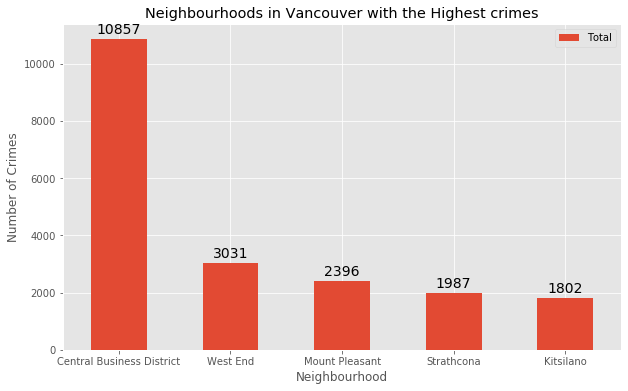

In [16]:

per_neigh = crime_neigh_top5[['Neighbourhood','Total']]

per_neigh.set_index('Neighbourhood',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Vancouver with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

##### Five Neighborhoods with lowest crime rate

In [17]:
crime_neigh_low = vnc_crime_neigh.tail(5)
crime_neigh_low

,Neighbourhood,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
23,West Point Grey,18,71,50,11,157,32,11,0,22,372
0,Arbutus Ridge,12,78,49,18,111,12,12,1,18,311
17,South Cambie,22,42,41,38,111,19,8,0,11,292
18,Stanley Park,6,2,8,0,109,14,3,0,12,154
12,Musqueam,0,4,3,0,4,2,2,0,2,17


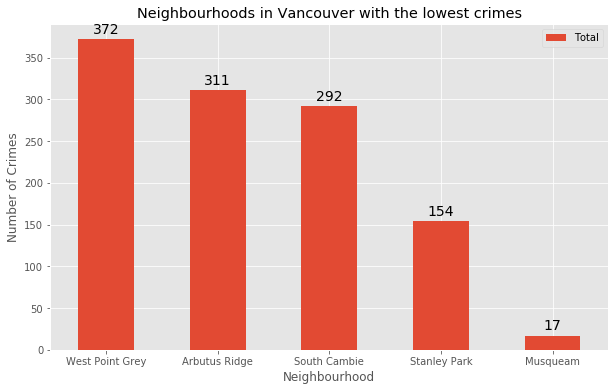

In [18]:
per_neigh = crime_neigh_low[['Neighbourhood','Total']]

per_neigh.set_index('Neighbourhood',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Vancouver with the lowest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

##### Borough in Vancouver with Highest Crime

In [19]:
vnc_crime_cat = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Borough'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_cat

Year                                    \
Type            Break and Enter Commercial Break and Enter Residential/Other   
Borough                                                                        
Central                                787                               198   
East Side                              786                              1043   
South Vancouver                         49                               156   
West Side                              403                              1000   
All                                   2025                              2397   

                                                                          \
Type            Mischief Other Theft Theft from Vehicle Theft of Bicycle   
Borough                                                                    
Central             2280        2489               6871              857   
East Side           2192        1674               4754              678   
South Vancouver      187          88                483               36   
West Side           1062         696               2838              588   
All                 5721        4947              14946             2159   

                                  \
Type            Theft of Vehicle   
Borough                            
Central                      245   
East Side                    605   
South Vancouver               71   
West Side                    225   
All                         1146   

                                                                        \
Type            Vehicle Collision or Pedestrian Struck (with Fatality)   
Borough                                                                  
Central                                                          1       
East Side                                                        8       
South Vancouver                                                  1       
West Side                                                        3       
All                                                             13       

                                                                             
Type            Vehicle Collision or Pedestrian Struck (with Injury)    All  
Borough                                                                      
Central                                                        314    14042  
East Side                                                      660    12400  
South Vancouver                                                111     1182  
West Side                                                      389     7204  
All                                                           1474    34828

In [20]:
vnc_crime_cat.reset_index(inplace = True)
vnc_crime_cat.columns = vnc_crime_cat.columns.map(''.join)
vnc_crime_cat.rename(columns={'YearAll':'Total',
                              'YearBreak and Enter Commercial' : 'Break and Enter Commercial',
                              'YearBreak and Enter Residential/Other' : 'Break and Enter Residential',
                              'YearMischief' : 'Mischief',
                              'YearOther Theft' : 'Other',
                              'YearTheft from Vehicle' : 'Theft from Vehicle',
                              'YearTheft of Bicycle' : 'Theft of Bicycle',
                              'YearTheft of Vehicle' : 'Theft of Vehicle',
                              'YearVehicle Collision or Pedestrian Struck (with Fatality)' : 'Vehicle Collision or Pedestrian Struck (with Fatality)',
                              'YearVehicle Collision or Pedestrian Struck (with Injury)' : 'Vehicle Collision or Pedestrian Struck (with Injury)'}, inplace=True)
# To ignore bottom All in Borough
vnc_crime_cat = vnc_crime_cat.head(4)
vnc_crime_cat

,Borough,Break and Enter Commercial,Break and Enter Residential,Mischief,Other,Theft from Vehicle,Theft of Bicycle,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with Fatality),Vehicle Collision or Pedestrian Struck (with Injury),Total
0,Central,787,198,2280,2489,6871,857,245,1,314,14042
1,East Side,786,1043,2192,1674,4754,678,605,8,660,12400
2,South Vancouver,49,156,187,88,483,36,71,1,111,1182
3,West Side,403,1000,1062,696,2838,588,225,3,389,7204


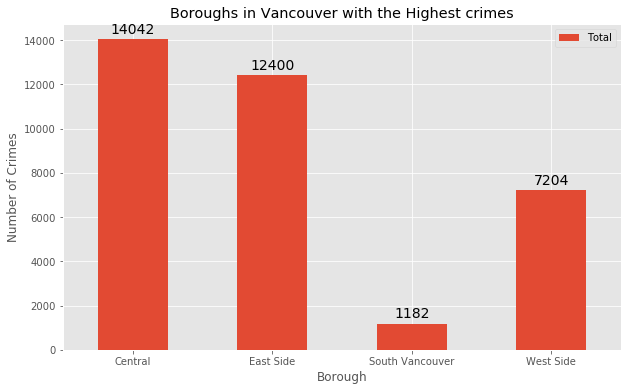

In [21]:
per_borough = vnc_crime_cat[['Borough','Total']]

per_borough.set_index('Borough',inplace = True)

ax = per_borough.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Boroughs in Vancouver with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

##### With the analysis it can be concluded that South Vancouver has lowest crime rate. Since South Vancouver has very lowest number of neighborhoods and opening a commercial establishment would not be viable, we can choose the next borough with lowest crime which is West Side. It is also noted that West side has lowest number of break and enter, thus makes West Side an ideal location for the commercial establishment.

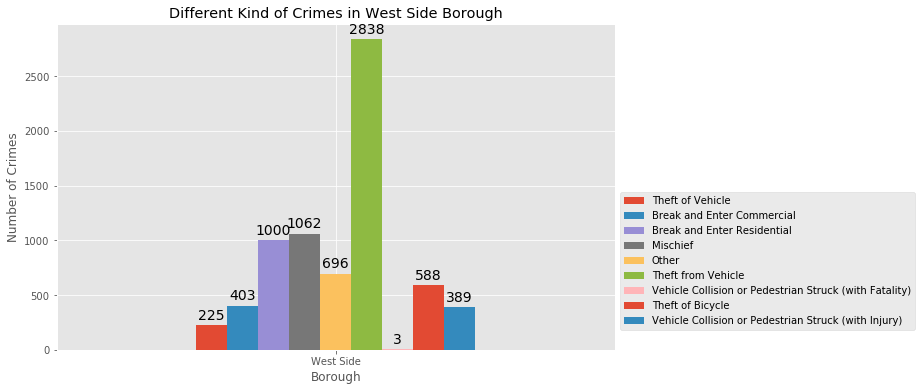

In [23]:

vnc_ws_df = vnc_crime_cat[vnc_crime_cat['Borough'] == 'West Side']

vnc_ws_df = vnc_ws_df.sort_values(['Total'], ascending = True, axis = 0)

vnc_ws = vnc_ws_df[['Borough','Theft of Vehicle', 'Break and Enter Commercial','Break and Enter Residential','Mischief','Other',
                 'Theft from Vehicle','Vehicle Collision or Pedestrian Struck (with Fatality)','Theft of Bicycle',
                 'Vehicle Collision or Pedestrian Struck (with Injury)']]


vnc_ws.set_index('Borough',inplace = True)

ax = vnc_ws.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Different Kind of Crimes in West Side Borough')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=3), 
                (p.get_x()+p.get_width()/3., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(5, 10), 
                textcoords='offset points',
                fontsize = 14
               )
    ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.5))

plt.show()

## Executing Step 3

In [24]:
vnc_ws_neigh = vnc_boroughs_crime

#vnc_ws_neigh.drop(['Type','Year', 'Month', 'Day', 'Hour'], axis = 1, inplace = True)
vnc_ws_neigh = vnc_ws_neigh[vnc_ws_neigh['Borough'] == 'West Side']
vnc_ws_neigh.reset_index(inplace=True, drop=True)

print('Number of Neighbourhoods in West Side Borough', len(vnc_ws_neigh['Neighbourhood'].unique()))

vnc_ws_neigh['Neighbourhood'].unique()

Number of Neighbourhoods in West Side Borough 10


array(['Shaughnessy', 'Fairview', 'Oakridge', 'Marpole', 'Kitsilano',
       'Kerrisdale', 'West Point Grey', 'Arbutus Ridge', 'South Cambie',
       'Dunbar-Southlands'], dtype=object)

#### Creating a new Data frame with Lat, Lng being fetched from OpenCage geocoder

In [25]:
Latitude = []
Longitude = []
Borough = []
Neighbourhood = vnc_ws_neigh['Neighbourhood'].unique()



key = '830323b5ca694362904814ff0a11b803'
geocoder = OpenCageGeocode(key)

for i in range(len(Neighbourhood)):
    address = '{}, Vancouver, BC, Canada'.format(Neighbourhood[i])
    location = geocoder.geocode(address)
    Latitude.append(location[0]['geometry']['lat'])
    Longitude.append(location[0]['geometry']['lng'])
    Borough.append('West Side')
print(Latitude, Longitude)

#print('The geograpical coordinate of Vancouver City are {}, {}.'.format(latitude, longitude))

[49.2518626, 49.2641128, 49.2308288, 49.2092233, 49.2694099, 49.2346728, 49.2644843, 49.2409677, 49.2466847, 49.2534601] [-123.1380226, -123.1268352, -123.1311342, -123.1361495, -123.155267, -123.1553893, -123.1854326, -123.1670008, -123.120915, -123.1850439]


##### Reviewing the new Data Frame with Neighborhoods in West Side Borough of Vancouver along with centroid of the co-ordinates.

In [26]:
ws_neig_dict = {'Neighbourhood': Neighbourhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
ws_neig_geo = pd.DataFrame(data=ws_neig_dict, columns=['Neighbourhood', 'Borough', 'Latitude', 'Longitude'], index=None)

ws_neig_geo

,Neighbourhood,Borough,Latitude,Longitude
0,Shaughnessy,West Side,49.251863,-123.138023
1,Fairview,West Side,49.264113,-123.126835
2,Oakridge,West Side,49.230829,-123.131134
3,Marpole,West Side,49.209223,-123.136150
4,Kitsilano,West Side,49.269410,-123.155267
5,Kerrisdale,West Side,49.234673,-123.155389
6,West Point Grey,West Side,49.264484,-123.185433
7,Arbutus Ridge,West Side,49.240968,-123.167001
8,South Cambie,West Side,49.246685,-123.120915
9,Dunbar-Southlands,West Side,49.253460,-123.185044


##### Fetching Vancouver Geographical coordinates

In [27]:
address = 'Vancouver, BC, Canada'

location = geocoder.geocode(address)
latitude = location[0]['geometry']['lat']
longitude = location[0]['geometry']['lng']

print('The geograpical coordinate of Vancouver, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Vancouver, Canada are 49.2608724, -123.1139529.


##### Using Folium to plot Vancouver City's West Side Borough and it's Neighborhoods

In [28]:
van_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(ws_neig_geo['Latitude'], ws_neig_geo['Longitude'], ws_neig_geo['Borough'], ws_neig_geo['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(van_map)  
    
van_map

### Executing Part 4

#### Setting Up Foursquare Credentials

In [29]:
#Four Square Credentials

CLIENT_ID = '0U1W0WFSNZWYOUAHVOSS1DS2EJTKKYVKQXIGA2GMJK2TVO53'
CLIENT_SECRET = 'U2US4220HQS5LTIR4P0FJXSADV2TSLBVHOXEX4E1HQSTCNCI'
VERSION = '20200129'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0U1W0WFSNZWYOUAHVOSS1DS2EJTKKYVKQXIGA2GMJK2TVO53
CLIENT_SECRET:U2US4220HQS5LTIR4P0FJXSADV2TSLBVHOXEX4E1HQSTCNCI


#### Defining a function to fetch top 10 venues

In [30]:

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

#### Generating Venues

In [31]:
vnc_ws_venues = getNearbyVenues(names=ws_neig_geo['Neighbourhood'],
                                   latitudes=ws_neig_geo['Latitude'],
                                   longitudes=ws_neig_geo['Longitude']
                                  )

Shaughnessy
Fairview
Oakridge
Marpole
Kitsilano
Kerrisdale
West Point Grey
Arbutus Ridge
South Cambie
Dunbar-Southlands


#### Data frame containing venues for each West Side neighborhood 

In [32]:
print(vnc_ws_venues.shape)
vnc_ws_venues.head()

(231, 5)


,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category
0,Shaughnessy,49.251863,-123.138023,Angus Park,Park
1,Shaughnessy,49.251863,-123.138023,Crepe & Cafe,French Restaurant
2,Fairview,49.264113,-123.126835,Gyu-Kaku Japanese BBQ,BBQ Joint
3,Fairview,49.264113,-123.126835,CRESCENT nail and spa,Nail Salon
4,Fairview,49.264113,-123.126835,Charleson Park,Park


#### Venue Count per neighborhood

In [33]:
vnc_ws_venues.groupby('Neighbourhood').count().drop(['Neighborhood Latitude','Neighborhood Longitude','Venue Category'], axis = 1)

,Venue
Neighbourhood,
Arbutus Ridge,5
Dunbar-Southlands,7
Fairview,26
Kerrisdale,38
Kitsilano,48
Marpole,32
Oakridge,7
Shaughnessy,2
South Cambie,18


In [34]:
print('There are {} uniques categories.'.format(len(vnc_ws_venues['Venue Category'].unique())))

There are 86 uniques categories.


## Modeling Data

#### One Hot Encoding to Analyze Each Neighborhood

In [35]:

# one hot encoding
vnc_onehot = pd.get_dummies(vnc_ws_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
vnc_onehot['Neighbourhood'] = vnc_ws_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [vnc_onehot.columns[-1]] + list(vnc_onehot.columns[:-1])
vnc_onehot = vnc_onehot[fixed_columns]

vnc_onehot.head()

,Neighbourhood,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beach,Bookstore,Boutique,Breakfast Spot,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Café,Camera Store,Cantonese Restaurant,Chinese Restaurant,Coffee Shop,Convenience Store,Cosmetics Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Falafel Restaurant,Fast Food Restaurant,Food Truck,French Restaurant,Gas Station,Gastropub,Greek Restaurant,Grocery Store,Gym Pool,Hobby Shop,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Men's Store,Music Store,Nail Salon,Nightlife Spot,Noodle House,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Portuguese Restaurant,Pub,Rest Area,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,Spa,Sporting Goods Shop,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tea Room,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Shop,Yoga Studio
0,Shaughnessy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Shaughnessy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Fairview,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Fairview,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Fairview,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
vnc_onehot.shape

(231, 87)

In [37]:
vnc_ws_grouped = vnc_onehot.groupby('Neighbourhood').mean().reset_index()
vnc_ws_grouped

,Neighbourhood,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Beach,Bookstore,Boutique,Breakfast Spot,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Café,Camera Store,Cantonese Restaurant,Chinese Restaurant,Coffee Shop,Convenience Store,Cosmetics Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Falafel Restaurant,Fast Food Restaurant,Food Truck,French Restaurant,Gas Station,Gastropub,Greek Restaurant,Grocery Store,Gym Pool,Hobby Shop,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Men's Store,Music Store,Nail Salon,Nightlife Spot,Noodle House,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Portuguese Restaurant,Pub,Rest Area,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,Spa,Sporting Goods Shop,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tea Room,Tennis Court,Thai Restaurant,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Shop,Yoga Studio
0,Arbutus Ridge,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Dunbar-Southlands,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.00000,0.142857,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.285714,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Fairview,0.000000,0.076923,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.038462,0.192308,0.000000,0.000000,0.000000,0.000000,0.00000,0.038462,0.038462,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.038462,0.000000,0.038462,0.000000,0.00000,0.000000,0.000000,0.000000,0.038462,0.00000,0.000000,0.000000,0.000000,0.038462,0.0,0.000000,0.076923,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.038462,0.038462,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.038462,0.038462,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.000000,0.000000
3,Kerrisdale,0.000000,0.026316,0.000000,0.052632,0.026316,0.000000,0.000000,0.000000,0.026316,0.000000,0.026316,0.026316,0.000000,0.000000,0.026316,0.000000,0.000000,0.105263,0.105263,0.026316,0.000000,0.000000,0.026316,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.026316,0.026316,0.026316,0.000000,0.026316,0.026316,0.000000,0.000000,0.000000,0.00000,0.026316,0.000000,0.000000,0.000000,0.000

In [38]:
vnc_ws_grouped.shape

(10, 87)

#### Top five venues across neighborhood

In [39]:
num_top_venues = 5

for hood in vnc_ws_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = vnc_ws_grouped[vnc_ws_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arbutus Ridge----
            venue  freq
0   Grocery Store   0.2
1          Bakery   0.2
2             Spa   0.2
3  Nightlife Spot   0.2
4       Pet Store   0.2


----Dunbar-Southlands----
                venue  freq
0    Sushi Restaurant  0.29
1        Liquor Store  0.14
2         Coffee Shop  0.14
3  Italian Restaurant  0.14
4   Indian Restaurant  0.14


----Fairview----
              venue  freq
0       Coffee Shop  0.19
1  Asian Restaurant  0.08
2              Park  0.08
3             Diner  0.04
4  Sushi Restaurant  0.04


----Kerrisdale----
                venue  freq
0         Coffee Shop  0.11
1  Chinese Restaurant  0.11
2              Bakery  0.05
3            Pharmacy  0.05
4    Sushi Restaurant  0.05


----Kitsilano----
                 venue  freq
0               Bakery  0.08
1  American Restaurant  0.04
2     Sushi Restaurant  0.04
3           Food Truck  0.04
4       Ice Cream Shop  0.04


----Marpole----
                venue  freq
0    Sushi Restaurant  0.09
1     

#### Creating new dataframe and display the top 10 venues for each neighborhood

In [40]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = vnc_ws_grouped['Neighbourhood']

for ind in np.arange(vnc_ws_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vnc_ws_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arbutus Ridge,Bakery,Pet Store,Grocery Store,Spa,Nightlife Spot,Yoga Studio,Gas Station,Dim Sum Restaurant,Diner,Falafel Restaurant
1,Dunbar-Southlands,Sushi Restaurant,Liquor Store,Coffee Shop,Italian Restaurant,Indian Restaurant,Ice Cream Shop,Gas Station,Dim Sum Restaurant,Diner,Falafel Restaurant
2,Fairview,Coffee Shop,Park,Asian Restaurant,Chinese Restaurant,Pharmacy,Diner,Nail Salon,Indian Restaurant,Falafel Restaurant,Camera Store
3,Kerrisdale,Chinese Restaurant,Coffee Shop,Sandwich Place,Sushi Restaurant,Bakery,Tea Room,Pharmacy,Ice Cream Shop,Convenience Store,Pizza Place
4,Kitsilano,Bakery,American Restaurant,Thai Restaurant,Japanese Restaurant,Tea Room,Sushi Restaurant,Coffee Shop,Ice Cream Shop,Food Truck,French Restaurant


### Cluster Neighborhoods

In [42]:
# set number of clusters
kclusters = 5

vnc_grouped_clustering = vnc_ws_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vnc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 4, 0, 0, 0, 0, 3, 2, 0, 0], dtype=int32)

In [43]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

vancouver_merged = ws_neig_geo

# merge toronto_grouped with Vancouver data to add latitude/longitude for each neighborhood
vancouver_merged = vancouver_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

vancouver_merged.head()

,Neighbourhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Shaughnessy,West Side,49.251863,-123.138023,2,French Restaurant,Park,Yoga Studio,Gastropub,Dim Sum Restaurant,Diner,Falafel Restaurant,Fast Food Restaurant,Food Truck,Gas Station
1,Fairview,West Side,49.264113,-123.126835,0,Coffee Shop,Park,Asian Restaurant,Chinese Restaurant,Pharmacy,Diner,Nail Salon,Indian Restaurant,Falafel Restaurant,Camera Store
2,Oakridge,West Side,49.230829,-123.131134,3,Vietnamese Restaurant,Convenience Store,Pizza Place,Sandwich Place,Fast Food Restaurant,Sushi Restaurant,Bus Station,Yoga Studio,French Restaurant,Dim Sum Restaurant
3,Marpole,West Side,49.209223,-123.136150,0,Chinese Restaurant,Pizza Place,Sushi Restaurant,Bus Stop,Lingerie Store,Liquor Store,Dessert Shop,Dim Sum Restaurant,Plaza,Massage Studio
4,Kitsilano,West Side,49.269410,-123.155267,0,Bakery,American Restaurant,Thai Restaurant,Japanese Restaurant,Tea Room,Sushi Restaurant,Coffee Shop,Ice Cream Shop,Food Truck,French Restaurant


In [44]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vancouver_merged['Latitude'], vancouver_merged['Longitude'], vancouver_merged['Neighbourhood'], vancouver_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Interpreting the Analysis

#### Reviewing the results from clustering

#### Cluster 1

In [45]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 0, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,West Side,Coffee Shop,Park,Asian Restaurant,Chinese Restaurant,Pharmacy,Diner,Nail Salon,Indian Restaurant,Falafel Restaurant,Camera Store
3,West Side,Chinese Restaurant,Pizza Place,Sushi Restaurant,Bus Stop,Lingerie Store,Liquor Store,Dessert Shop,Dim Sum Restaurant,Plaza,Massage Studio
4,West Side,Bakery,American Restaurant,Thai Restaurant,Japanese Restaurant,Tea Room,Sushi Restaurant,Coffee Shop,Ice Cream Shop,Food Truck,French Restaurant
5,West Side,Chinese Restaurant,Coffee Shop,Sandwich Place,Sushi Restaurant,Bakery,Tea Room,Pharmacy,Ice Cream Shop,Convenience Store,Pizza Place
6,West Side,Japanese Restaurant,Coffee Shop,Sushi Restaurant,Café,Vegetarian / Vegan Restaurant,Bus Station,Pizza Place,Pub,Bookstore,Convenience Store
8,West Side,Coffee Shop,Bus Stop,Park,Vietnamese Restaurant,Light Rail Station,Bank,Juice Bar,Malay Restaurant,Sushi Restaurant,Supermarket


####  Cluster 2

In [47]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 1, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,West Side,Bakery,Pet Store,Grocery Store,Spa,Nightlife Spot,Yoga Studio,Gas Station,Dim Sum Restaurant,Diner,Falafel Restaurant


####  Cluster 3

In [48]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 2, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,West Side,French Restaurant,Park,Yoga Studio,Gastropub,Dim Sum Restaurant,Diner,Falafel Restaurant,Fast Food Restaurant,Food Truck,Gas Station


#### Cluster 4


In [49]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 3, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,West Side,Vietnamese Restaurant,Convenience Store,Pizza Place,Sandwich Place,Fast Food Restaurant,Sushi Restaurant,Bus Station,Yoga Studio,French Restaurant,Dim Sum Restaurant


#### Cluster 5

In [50]:
vancouver_merged.loc[vancouver_merged['Cluster Labels'] == 4, vancouver_merged.columns[[1] + list(range(5, vancouver_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,West Side,Sushi Restaurant,Liquor Store,Coffee Shop,Italian Restaurant,Indian Restaurant,Ice Cream Shop,Gas Station,Dim Sum Restaurant,Diner,Falafel Restaurant


## Results and Discussion
#### The objective of this project was to help stakeholders identify one of the safest borough in Vancouver, and an appropriate neighborhood within the borough to set up a commercial establishment especially a liquor store. This has been achieved by first analyzing Vancouver crime data to identify a safe borough with considerable number of neighborhood for any business to be viable. After selecting the borough it was imperative to choose the right neighborhood where liquor shops were not among venues in a close proximity to each other. This was achieved by grouping the neighborhoods into clusters to assist the stakeholders by providing them with relevant data about venues and safety of a given neighborhood.

## Conclusion
#### This project has explored the crime data to understand different types of crimes rate in all neighborhoods of Vancouver. Then categorized the data into different boroughs, this helped identify the safest borough. Once the borough was confirmed, the number of neighborhoods for consideration also were significantly reduced. Also, there was further shortlist the neighborhoods based on the common venues, and to choose a neighborhood which best resolves the business problem.